## Image classifier (least squares method)

This is simple classifier based on [least squares method](https://en.wikipedia.org/wiki/Least_squares).

First of all, let's import numpy and time libraries. 

In [1]:
import numpy as np
import time

Now, let's read the data. It is written in two files (<i>mnist_train.csv</i> and <i>mnist_test.csv</i>) picked from [here](https://pjreddie.com/projects/mnist-in-csv/). 

<b>Attention!</b> Reading and parsing big csv files needs some memory (up to a couple of gigabytes) and some calculation power, so it's better to run the following block of code only once.

In [2]:
train_data = np.loadtxt("mnist_train.csv", delimiter=',')
test_data = np.loadtxt("mnist_test.csv", delimiter=',')

As you can see, we have 60k vectors representing images in `train_data` and 10k vectors in `test_data`. Every vector has 785 values - first one is the tag (a digit from 0 to 9) and next 784 numbers represent the image of this digit (actually it is reshaped 28x28 matrix of pixels, modified for easier processing).

In [3]:
print(train_data.shape)
print(test_data.shape)

(60000, 785)
(10000, 785)


So, let's start. Our algorithm has complexity of $O(N \times M \times L)$, where $N$ is the size of train selection, $M$ is the size of test selection and $L$ represents the length of vectors in selections. Therefore, we need to choose  subsets of our selections and  work with it, no with the full data. 

We still can take full data, but then computations will require a lot of time.

In [4]:
train_size = 10000
test_size = 1000
IMAGE_LENGTH = test_data.shape[1] - 1

In [5]:
def get_random_subset(data, new_size):
    old_size = data.shape[0]
    indexes = np.random.choice(old_size, new_size, replace = False)
    labels = data[indexes, 0].astype(int)
    images = data[indexes, 1:]
    return labels, images

train_labels, train_img = get_random_subset(train_data, train_size)
test_labels, test_img = get_random_subset(test_data, test_size)

Now, let's write our classifier itself. As said above, we will use the least squares method. 

How does it work?
For every sample from test selection (which is a vector), we need to find the closest (by Euclidean distance) vector from train selection. The label of the closest vector will be the "predicted" label of vector from test selection.


<b>Comment:</b> for small sizes of test and train subsets we could vectorize our algorithm by creating matrix of Euclidean distance between each pair of vectors. However, it will rise memory usage which is critical for huge subsets of images.   

In [6]:
def classify_image(test_img, train_img, train_labels):
    DM = np.square(test_img - train_img).sum(axis = 1)
    index = DM.argmin(axis = 0)
    return train_labels[index]

Now let's test our algorithm. We will also measure time of execution using `time` library. 

In [7]:
%%time

predicted_results = [classify_image(test, train_img, train_labels) 
                     for test in test_img]

success_count = (predicted_results == test_labels).sum()
accuracy = success_count / test_size

print("SAMPLES COUNT :", train_size)
print("TESTS COUNT   :", test_size)
print("ACCURACY      :", np.round(accuracy * 100, 2), '%')

SAMPLES COUNT : 10000
TESTS COUNT   : 1000
ACCURACY      : 94.4 %
CPU times: user 1min 36s, sys: 2.94 s, total: 1min 39s
Wall time: 49.9 s


Well done!

Now let's see how accuracy depends on size of train subset. Since small subsets has more contribution of random in result accuracy, we need to choose different subsets and run our classifier on each. As a result, we will take the average value of accuracy as our accuracy for a specific size of subset.

In [8]:
def get_average_accuracy(test_img, train_data, train_subset_size, iterations_count):
    total_accuracy = 0
    
    for i in range(iterations_count):
        train_labels, train_img = get_random_subset(train_data, train_subset_size)        
        predicted_results = [classify_image(test, train_img, train_labels) 
                             for test in test_img]
        success_count = (predicted_results == test_labels).sum()
        total_accuracy += success_count / test_labels.shape[0]
   
    return total_accuracy / iterations_count

In [9]:
%%time

size_of_subset_v = [50,  200, 500, 1000, 2000, 5000, 10000]
count_of_iters_v = [100, 40,  20,  15,   10,   3,    1]

accuracy_info = [get_average_accuracy(test_img, train_data, size, iters)
                    for size, iters in zip(size_of_subset_v, count_of_iters_v)]

CPU times: user 11min 46s, sys: 48.4 s, total: 12min 35s
Wall time: 6min 39s


Let's visualize our results using $matplotlib$. Note that x-axis is logarithmically scaled.

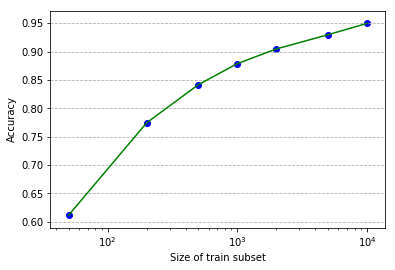

In [11]:
import matplotlib.pyplot as plt

plt.semilogx(size_of_subset_v, accuracy_info, color = "g")
plt.scatter(size_of_subset_v, accuracy_info, color = "b")

plt.xlabel("Size of train subset")
plt.ylabel("Accuracy")
plt.grid(axis="y", which="both", linestyle='--')

plt.show()

As it was expected, the accuracy depends on size of train subset. 

#### Summary: 
Least squares method is quite good for such type of dataset. It is easy-to-understand and easy-to-code, but it is very sensitive for bad data. Plus this method has to work with the full train dataset every time we want to get prediction. 

So, you could choose this method if:
* Your dataset is well-separated and clear (has no wrong data) 
* It's easy to separate test data using the small subset of train data
* You have no time for understanding and coding better and more complex soutions
